<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/auduvignac/challengedata_ens_AssurPrime/blob/main/notebooks/exploration/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

##Installation de category-encoder

In [ ]:
!pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00


##Importation des bibliothèques

In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
pd.set_option('display.max_columns', 375)
import numpy as np
from category_encoders import CountEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

##Chargement des données

In [ ]:
# Charger les données
try:
  print("Chargement des données...")
  X_train_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/x_train.csv"
  X_train = pd.read_csv(X_train_url)
  y_train_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/y_train.csv"
  y_train = pd.read_csv(y_train_url)
  X_test_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/x_test.csv"
  X_test = pd.read_csv(X_test_url)
  print("Données chargées avec succès.")
except:
  print("Erreur lors du chargement des données. Vérifiez que les URLs sont correctes.")

Chargement des données...


<ipython-input-3-c5aaf42838da>:5: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_train = pd.read_csv(X_train_url)
<ipython-input-3-c5aaf42838da>:9: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test = pd.read_csv(X_test_url)


Données chargées avec succès.


##Sauvegarde des dataframes avant transformations

###Remarques
Ce n'est peut être pas le meilleur moment pour conserver une copie du dataframe en input.

En effet, je m'interroge à savoir s'il ne serait pas plus judicieux de conserver les X_train, y_train et X_test d'origine sans les changer et créer deux jeux de dataframes pour respectivement prédire la frequence et le coût unitaire. Car il est probable que ce ne sont pas les mêmes features qui sont utiles aux deux modèles.

Par exemple : Kapitalnn qui correspond au capital assuré peut être pertinent pour estimer les coût unitaire d'un incendie, mais pas sa frequence (sauf à considérer que l'on a à intégrer de la fraude).

In [ ]:
# Sauvegarde des dataframes
X_train_save = X_train.copy()
y_train_save = y_train.copy()
X_test_save = X_test.copy()

##Analyse des données

In [ ]:
# Afficher un aperçu des données pour vérifier leur chargement
print("Aperçu de X_train :")
display(X_train.head())
print("Aperçu de y_train :")
display(y_train.head())
print("Aperçu de X_test :")
display(X_test.head())

Aperçu de X_train :


,ID,ACTIVIT2,VOCATION,TYPERS,ANCIENNETE,ADOSS,CARACT1,CARACT2,CARACT3,INDEM1,DUREE_REQANEUF,CARACT4,CARACT5,TYPBAT1,INDEM2,TYPBAT2,FRCH1,FRCH2,DEROG1,DEROG2,DEROG3,DEROG4,DEROG5,DEROG6,DEROG7,DEROG8,DEROG9,DEROG10,DEROG11,DEROG12,DEROG13,DEROG14,DEROG15,DEROG16,TAILLE1,TAILLE2,CA1,CA2,CA3,KAPITAL1,KAPITAL2,KAPITAL3,KAPITAL4,KAPITAL5,KAPITAL6,KAPITAL7,KAPITAL8,KAPITAL9,KAPITAL10,KAPITAL11,KAPITAL12,KAPITAL13,KAPITAL14,KAPITAL15,KAPITAL16,KAPITAL17,KAPITAL18,KAPITAL19,KAPITAL20,KAPITAL21,KAPITAL22,KAPITAL23,KAPITAL24,KAPITAL25,KAPITAL26,KAPITAL27,KAPITAL28,KAPITAL29,KAPITAL30,KAPITAL31,KAPITAL32,KAPITAL33,KAPITAL34,KAPITAL35,KAPITAL36,KAPITAL37,KAPITAL38,KAPITAL39,KAPITAL40,KAPITAL41,KAPITAL42,KAPITAL43,SURFACE1,SURFACE2,SURFACE3,SURFACE4,SURFACE5,SURFACE6,SURFACE7,SURFACE8,SURFACE9,SURFACE10,SURFACE11,SURFACE12,SURFACE13,SURFACE14,SURFACE15,SURFACE16,SURFACE17,SURFACE18,SURFACE19,SURFACE20,SURFACE21,NBBAT1,NBBAT2,NBBAT3,NBBAT4,NBBAT5,NBBAT6,NBBAT7,NBBAT8,NBBAT9,NBBAT10,NBBAT11,NBBAT13,NBBAT14,TAILLE3,TAILLE4,NBSINCONJ,NBSINSTRT,COEFASS,RISK1,RISK2,RISK3,RISK4,RISK5,RISK6,RISK7,RISK8,RISK9,RISK10,RISK11,RISK12,RISK13,EQUIPEMENT1,EQUIPEMENT2,EQUIPEMENT3,EQUIPEMENT4,EQUIPEMENT5,EQUIPEMENT6,EQUIPEMENT7,DISTANCE_111,DISTANCE_112,DISTANCE_121,DISTANCE_122,DISTANCE_123,DISTANCE_124,DISTANCE_131,DISTANCE_132,DISTANCE_133,DISTANCE_141,DISTANCE_142,DISTANCE_211,DISTANCE_212,DISTANCE_213,DISTANCE_221,DISTANCE_222,DISTANCE_223,DISTANCE_231,DISTANCE_242,DISTANCE_243,DISTANCE_244,DISTANCE_311,DISTANCE_312,DISTANCE_313,DISTANCE_321,DISTANCE_322,DISTANCE_323,DISTANCE_324,DISTANCE_331,DISTANCE_332,DISTANCE_333,DISTANCE_334,DISTANCE_335,DISTANCE_411,DISTANCE_412,DISTANCE_421,DISTANCE_422,DISTANCE_423,DISTANCE_511,DISTANCE_512,DISTANCE_521,DISTANCE_522,DISTANCE_523,PROPORTION_11,PROPORTION_12,PROPORTION_13,PROPORTION_14,PROPORTION_21,PROPORTION_22,PROPORTION_23,PROPORTION_24,PROPORTION_31,PROPORTION_32,PROPORTION_33,PROPORTION_41,PROPORTION_42,PROPORTION_51,PROPORTION_52,MEN,MEN_PAUV,MEN_1IND,MEN_5IND,MEN_PROP,MEN_FMP,MEN_COLL,MEN_MAIS,LOG_AVA1,LOG_A1_A2,LOG_A2_A3,LOG_APA3,LOG_INC,LOG_SOC,IND,IND_0_Y1,IND_Y1_Y2,IND_Y2_Y3,IND_Y3_Y4,IND_Y4_Y5,IND_Y5_Y6,IND_Y6_Y7,IND_Y7_Y8,IND_Y8_Y9,IND_Y9,IND_INC,IND_SNV,MEN_SURF,DISTANCE_1,DISTANCE_2,ALTITUDE_1,ALTITUDE_2,ALTITUDE_3,ALTITUDE_4,ALTITUDE_5,BDTOPO_BAT_MAX_HAUTEUR_MAX,HAUTEUR,HAUTEUR_MAX,BDTOPO_BAT_MAX_HAUTEUR,ZONE_VENT,NB_CASERNES,NBJTX25_MM_A,NBJTX25_MMAX_A,NBJTX25_MSOM_A,NBJTX0_MM_A,NBJTX0_MMAX_A,NBJTX0_MSOM_A,NBJTXI27_MM_A,NBJTXI27_MMAX_A,NBJTXI27_MSOM_A,NBJTXS32_MM_A,NBJTXS32_MMAX_A,NBJTXS32_MSOM_A,NBJTXI20_MM_A,NBJTXI20_MMAX_A,NBJTXI20_MSOM_A,NBJTX30_MM_A,NBJTX30_MMAX_A,NBJTX30_MSOM_A,NBJTX35_MM_A,NBJTX35_MMAX_A,NBJTX35_MSOM_A,NBJTN10_MM_A,NBJTN10_MMAX_A,NBJTN10_MSOM_A,NBJTNI10_MM_A,NBJTNI10_MMAX_A,NBJTNI10_MSOM_A,NBJTN5_MM_A,NBJTN5_MMAX_A,NBJTN5_MSOM_A,NBJTNS25_MM_A,NBJTNS25_MMAX_A,NBJTNS25_MSOM_A,NBJTNI15_MM_A,NBJTNI15_MMAX_A,NBJTNI15_MSOM_A,NBJTNI20_MM_A,NBJTNI20_MMAX_A,NBJTNI20_MSOM_A,NBJTNS20_MM_A,NBJTNS20_MMAX_A,NBJTNS20_MSOM_A,NBJTMS24_MM_A,NBJTMS24_MMAX_A,NBJTMS24_MSOM_A,TAMPLIAB_VOR_MM_A,TAMPLIAB_VOR_MMAX_A,TAMPLIM_VOR_MM_A,TAMPLIM_VOR_MMAX_A,TM_VOR_MM_A,TM_VOR_MMAX_A,TMM_VOR_MM_A,TMM_VOR_MMAX_A,TMMAX_VOR_MM_A,TMMAX_VOR_MMAX_A,TMMIN_VOR_MM_A,TMMIN_VOR_MMAX_A,TN_VOR_MM_A,TN_VOR_MMAX_A,TNAB_VOR_MM_A,TNAB_VOR_MMAX_A,TNMAX_VOR_MM_A,TNMAX_VOR_MMAX_A,TX_VOR_MM_A,TX_VOR_MMAX_A,TXAB_VOR_MM_A,TXAB_VOR_MMAX_A,TXMIN_VOR_MM_A,TXMIN_VOR_MMAX_A,NBJFF10_MM_A,NBJFF10_MMAX_A,NBJFF10_MSOM_A,NBJFF16_MM_A,NBJFF16_MMAX_A,NBJFF16_MSOM_A,NBJFF28_MM_A,NBJFF28_MMAX_A,NBJFF28_MSOM_A,NBJFXI3S10_MM_A,NBJFXI3S10_MMAX_A,NBJFXI3S10_MSOM_A,NBJFXI3S16_MM_A,NBJFXI3S16_MMAX_A,NBJFXI3S16_MSOM_A,NBJFXI3S28_MM_A,NBJFXI3S28_MMAX_A,NBJFXI3S28_MSOM_A,NBJFXY8_MM_A,NBJFXY8_MMAX_A,NBJFXY8_MSOM_A,NBJFXY10_MM_A,NBJFXY10_MMAX_A,NBJFXY10_MSOM_A,NBJFXY15_MM_A,NBJFXY15_MMAX_A,NBJFXY15_MSOM_A,FFM_VOR_MM_A,FFM_VOR_MMAX_A,FXI3SAB_VOR_MM_A,FXI3SAB_VOR_MMAX_A,FXIAB_VOR_MM_A,FXIAB_VOR_MMAX_A,FXYAB_VOR_MM_A,FXYAB_VOR_MMAX_A,FFM_VOR_COM_MM_A_Y

Aperçu de y_train :


,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE
0,1,0.0,0.0,1.000000,0.0
1,2,0.0,0.0,1.000000,0.0
2,3,0.0,0.0,0.402740,0.0
3,4,0.0,0.0,0.246575,0.0
4,5,0.0,0.0,0.838356,0.0


Aperçu de X_test :


,ID,ACTIVIT2,VOCATION,TYPERS,ANCIENNETE,ADOSS,CARACT1,CARACT2,CARACT3,INDEM1,DUREE_REQANEUF,CARACT4,CARACT5,TYPBAT1,INDEM2,TYPBAT2,FRCH1,FRCH2,DEROG1,DEROG2,DEROG3,DEROG4,DEROG5,DEROG6,DEROG7,DEROG8,DEROG9,DEROG10,DEROG11,DEROG12,DEROG13,DEROG14,DEROG15,DEROG16,TAILLE1,TAILLE2,CA1,CA2,CA3,KAPITAL1,KAPITAL2,KAPITAL3,KAPITAL4,KAPITAL5,KAPITAL6,KAPITAL7,KAPITAL8,KAPITAL9,KAPITAL10,KAPITAL11,KAPITAL12,KAPITAL13,KAPITAL14,KAPITAL15,KAPITAL16,KAPITAL17,KAPITAL18,KAPITAL19,KAPITAL20,KAPITAL21,KAPITAL22,KAPITAL23,KAPITAL24,KAPITAL25,KAPITAL26,KAPITAL27,KAPITAL28,KAPITAL29,KAPITAL30,KAPITAL31,KAPITAL32,KAPITAL33,KAPITAL34,KAPITAL35,KAPITAL36,KAPITAL37,KAPITAL38,KAPITAL39,KAPITAL40,KAPITAL41,KAPITAL42,KAPITAL43,SURFACE1,SURFACE2,SURFACE3,SURFACE4,SURFACE5,SURFACE6,SURFACE7,SURFACE8,SURFACE9,SURFACE10,SURFACE11,SURFACE12,SURFACE13,SURFACE14,SURFACE15,SURFACE16,SURFACE17,SURFACE18,SURFACE19,SURFACE20,SURFACE21,NBBAT1,NBBAT2,NBBAT3,NBBAT4,NBBAT5,NBBAT6,NBBAT7,NBBAT8,NBBAT9,NBBAT10,NBBAT11,NBBAT13,NBBAT14,TAILLE3,TAILLE4,NBSINCONJ,NBSINSTRT,COEFASS,RISK1,RISK2,RISK3,RISK4,RISK5,RISK6,RISK7,RISK8,RISK9,RISK10,RISK11,RISK12,RISK13,EQUIPEMENT1,EQUIPEMENT2,EQUIPEMENT3,EQUIPEMENT4,EQUIPEMENT5,EQUIPEMENT6,EQUIPEMENT7,DISTANCE_111,DISTANCE_112,DISTANCE_121,DISTANCE_122,DISTANCE_123,DISTANCE_124,DISTANCE_131,DISTANCE_132,DISTANCE_133,DISTANCE_141,DISTANCE_142,DISTANCE_211,DISTANCE_212,DISTANCE_213,DISTANCE_221,DISTANCE_222,DISTANCE_223,DISTANCE_231,DISTANCE_242,DISTANCE_243,DISTANCE_244,DISTANCE_311,DISTANCE_312,DISTANCE_313,DISTANCE_321,DISTANCE_322,DISTANCE_323,DISTANCE_324,DISTANCE_331,DISTANCE_332,DISTANCE_333,DISTANCE_334,DISTANCE_335,DISTANCE_411,DISTANCE_412,DISTANCE_421,DISTANCE_422,DISTANCE_423,DISTANCE_511,DISTANCE_512,DISTANCE_521,DISTANCE_522,DISTANCE_523,PROPORTION_11,PROPORTION_12,PROPORTION_13,PROPORTION_14,PROPORTION_21,PROPORTION_22,PROPORTION_23,PROPORTION_24,PROPORTION_31,PROPORTION_32,PROPORTION_33,PROPORTION_41,PROPORTION_42,PROPORTION_51,PROPORTION_52,MEN,MEN_PAUV,MEN_1IND,MEN_5IND,MEN_PROP,MEN_FMP,MEN_COLL,MEN_MAIS,LOG_AVA1,LOG_A1_A2,LOG_A2_A3,LOG_APA3,LOG_INC,LOG_SOC,IND,IND_0_Y1,IND_Y1_Y2,IND_Y2_Y3,IND_Y3_Y4,IND_Y4_Y5,IND_Y5_Y6,IND_Y6_Y7,IND_Y7_Y8,IND_Y8_Y9,IND_Y9,IND_INC,IND_SNV,MEN_SURF,DISTANCE_1,DISTANCE_2,ALTITUDE_1,ALTITUDE_2,ALTITUDE_3,ALTITUDE_4,ALTITUDE_5,BDTOPO_BAT_MAX_HAUTEUR_MAX,HAUTEUR,HAUTEUR_MAX,BDTOPO_BAT_MAX_HAUTEUR,ZONE_VENT,NB_CASERNES,NBJTX25_MM_A,NBJTX25_MMAX_A,NBJTX25_MSOM_A,NBJTX0_MM_A,NBJTX0_MMAX_A,NBJTX0_MSOM_A,NBJTXI27_MM_A,NBJTXI27_MMAX_A,NBJTXI27_MSOM_A,NBJTXS32_MM_A,NBJTXS32_MMAX_A,NBJTXS32_MSOM_A,NBJTXI20_MM_A,NBJTXI20_MMAX_A,NBJTXI20_MSOM_A,NBJTX30_MM_A,NBJTX30_MMAX_A,NBJTX30_MSOM_A,NBJTX35_MM_A,NBJTX35_MMAX_A,NBJTX35_MSOM_A,NBJTN10_MM_A,NBJTN10_MMAX_A,NBJTN10_MSOM_A,NBJTNI10_MM_A,NBJTNI10_MMAX_A,NBJTNI10_MSOM_A,NBJTN5_MM_A,NBJTN5_MMAX_A,NBJTN5_MSOM_A,NBJTNS25_MM_A,NBJTNS25_MMAX_A,NBJTNS25_MSOM_A,NBJTNI15_MM_A,NBJTNI15_MMAX_A,NBJTNI15_MSOM_A,NBJTNI20_MM_A,NBJTNI20_MMAX_A,NBJTNI20_MSOM_A,NBJTNS20_MM_A,NBJTNS20_MMAX_A,NBJTNS20_MSOM_A,NBJTMS24_MM_A,NBJTMS24_MMAX_A,NBJTMS24_MSOM_A,TAMPLIAB_VOR_MM_A,TAMPLIAB_VOR_MMAX_A,TAMPLIM_VOR_MM_A,TAMPLIM_VOR_MMAX_A,TM_VOR_MM_A,TM_VOR_MMAX_A,TMM_VOR_MM_A,TMM_VOR_MMAX_A,TMMAX_VOR_MM_A,TMMAX_VOR_MMAX_A,TMMIN_VOR_MM_A,TMMIN_VOR_MMAX_A,TN_VOR_MM_A,TN_VOR_MMAX_A,TNAB_VOR_MM_A,TNAB_VOR_MMAX_A,TNMAX_VOR_MM_A,TNMAX_VOR_MMAX_A,TX_VOR_MM_A,TX_VOR_MMAX_A,TXAB_VOR_MM_A,TXAB_VOR_MMAX_A,TXMIN_VOR_MM_A,TXMIN_VOR_MMAX_A,NBJFF10_MM_A,NBJFF10_MMAX_A,NBJFF10_MSOM_A,NBJFF16_MM_A,NBJFF16_MMAX_A,NBJFF16_MSOM_A,NBJFF28_MM_A,NBJFF28_MMAX_A,NBJFF28_MSOM_A,NBJFXI3S10_MM_A,NBJFXI3S10_MMAX_A,NBJFXI3S10_MSOM_A,NBJFXI3S16_MM_A,NBJFXI3S16_MMAX_A,NBJFXI3S16_MSOM_A,NBJFXI3S28_MM_A,NBJFXI3S28_MMAX_A,NBJFXI3S28_MSOM_A,NBJFXY8_MM_A,NBJFXY8_MMAX_A,NBJFXY8_MSOM_A,NBJFXY10_MM_A,NBJFXY10_MMAX_A,NBJFXY10_MSOM_A,NBJFXY15_MM_A,NBJFXY15_MMAX_A,NBJFXY15_MSOM_A,FFM_VOR_MM_A,FFM_VOR_MMAX_A,FXI3SAB_VOR_MM_A,FXI3SAB_VOR_MMAX_A,FXIAB_VOR_MM_A,FXIAB_VOR_MMAX_A,FXYAB_VOR_MM_A,FXYAB_VOR_MMAX_A,FFM_VOR_COM_MM_A_Y

###Aperçu général des données

In [ ]:
# 0. Afficher le type des données de X_train
pd.set_option('display.max_rows', None)
print("Types des données de X_train :")
print(X_train.dtypes)


Types des données de X_train :
ID                              int64
ACTIVIT2                       object
VOCATION                       object
TYPERS                          int64
ANCIENNETE                      int64
ADOSS                          object
CARACT1                        object
CARACT2                       float64
CARACT3                        object
INDEM1                         object
DUREE_REQANEUF                float64
CARACT4                        object
CARACT5                         int64
TYPBAT1                        object
INDEM2                         object
TYPBAT2                         int64
FRCH1                          object
FRCH2                          object
DEROG1                         object
DEROG2                         object
DEROG3                         object
DEROG4                         object
DEROG5                         object
DEROG6                         object
DEROG7                         object
DEROG8             

###Analyse
Des colonnes qui semblent être de même nature, ne sont pas de même type. Par exemple : Kapitalnn (int64, float64 et object)

Il y a beaucoup de caractéristiques (374) et la plupart sont de type 'object'.

In [ ]:
# 2. Calcul des valeurs manquantes
nb_missing = X_train.isnull().sum()
taux_missing = X_train.isnull().mean() * 100

# Création d'un DataFrame combiné
missing_info = pd.DataFrame({
    'Valeurs manquantes': nb_missing,
    'Taux (%)': taux_missing.round(2)
})

# Filtrage pour ne garder que les colonnes avec au moins une valeur manquante
missing_info = missing_info[missing_info['Valeurs manquantes'] > 0]

print(missing_info)


Valeurs manquantes :
CARACT1                         4633
CARACT2                       368284
CARACT3                       368284
DUREE_REQANEUF                 26573
TYPBAT1                       353336
INDEM2                         27372
FRCH2                          26573
DEROG12                       349078
DEROG13                       382317
DEROG14                       383602
DEROG16                       380358
KAPITAL11                     119005
KAPITAL15                        624
KAPITAL16                       1582
KAPITAL17                        889
KAPITAL18                         48
KAPITAL19                       1105
KAPITAL20                        268
KAPITAL21                       5373
KAPITAL22                       2595
KAPITAL23                       1161
KAPITAL24                        834
KAPITAL29                       3795
KAPITAL30                       3795
KAPITAL31                          3
KAPITAL33                          3
SURFACE3        

###Analyse

***Beaucoup de valeurs manquantes** pour bon nombre de caratéristiques. L'enjeu est d'identifier les caractéristiques qui de ce fait n'apprendront rien au modèle pour les écarter et ainsi commencer à réduire le nombre de caractéristiques à prendre en compte.*

***Par exemple :** DEROGnn a plus de 380000 valeurs manquantes sur 383610 lignes, soit 99% de valeurs manquantes. A minima pour prédire la frequence du risque incendie on peut considérer les caractérisques DEROGnn comme inutiles.*

Il convient d'arbitrer pour chaque caractéristique, fonction de la cible à prédire (Freq ou CN). Pour cela nous allons dans un premier temps calculer le taux de valeurs manquantes.

In [ ]:
# 3. Analyse des valeurs uniques
unique_values = X_train.nunique()
print("\nNombre de valeurs uniques par colonne :")
print(unique_values)


Nombre de valeurs uniques par colonne :
ID                            383610
ACTIVIT2                           9
VOCATION                           8
TYPERS                             2
ANCIENNETE                        12
ADOSS                              2
CARACT1                            3
CARACT2                            2
CARACT3                            3
INDEM1                             2
DUREE_REQANEUF                     4
CARACT4                            6
CARACT5                           16
TYPBAT1                            5
INDEM2                            12
TYPBAT2                            3
FRCH1                              9
FRCH2                              6
DEROG1                             2
DEROG2                             2
DEROG3                             2
DEROG4                             2
DEROG5                             2
DEROG6                             2
DEROG7                             2
DEROG8                            

###Analyse

On constate que beaucoup de caractéristiques ont un nombre de valeurs uniques limité (par exemple 4) et sont de type object. La table de contingence ci-dessous permet de constater que ces caractéristiques prennent pour valeur des plages de valeurs ("<= nn" ou ">= nn").

Pour les caclculs des modèles, il nous faut convertir ces objects en catégories numériques.

In [ ]:
# 4. Table de contingence pour les variables catégorielles
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"\nTable de contingence pour {col} :")
    print(X_train[col].value_counts())


Table de contingence pour ACTIVIT2 :
ACTIVIT2
ACT1    296563
ACT5     53709
ACT2     14359
ACT8      5650
ACT3      5335
ACT9      4459
ACT7      2201
ACT6      1007
ACT4       327
Name: count, dtype: int64

Table de contingence pour VOCATION :
VOCATION
VOC6    244441
VOC8     67446
VOC7     38967
VOC4     15289
VOC1     14359
VOC2      1952
VOC3      1081
VOC5        75
Name: count, dtype: int64

Table de contingence pour ADOSS :
ADOSS
N    375557
O      8053
Name: count, dtype: int64

Table de contingence pour CARACT1 :
CARACT1
N    274335
R     93158
O     11484
Name: count, dtype: int64

Table de contingence pour CARACT3 :
CARACT3
N    7433
O    6795
R    1098
Name: count, dtype: int64

Table de contingence pour INDEM1 :
INDEM1
N    365728
O     17882
Name: count, dtype: int64

Table de contingence pour CARACT4 :
CARACT4
absence de surface    365009
Surface de moins d     10343
Surface entre 501       5205
Surface entre 1001      1600
Surface entre 1501       933
Surface de plus d

In [ ]:
# 1. Aperçu des données - informations statistiques
print("\nAperçu des données :")
print(X_train.info())
print("\nRésumé statistique :")
print(X_train.describe(include='all'))



Aperçu des données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Columns: 374 entries, ID to ZONE
dtypes: float64(36), int64(58), object(280)
memory usage: 1.1+ GB
None

Résumé statistique :
                   ID ACTIVIT2 VOCATION         TYPERS     ANCIENNETE   ADOSS  \
count   383610.000000   383610   383610  383610.000000  383610.000000  383610   
unique            NaN        9        8            NaN            NaN       2   
top               NaN     ACT1     VOC6            NaN            NaN       N   
freq              NaN   296563   244441            NaN            NaN  375557   
mean    191805.500000      NaN      NaN       1.665368       5.175517     NaN   
std     110738.812719      NaN      NaN       0.471862       3.823097     NaN   
min          1.000000      NaN      NaN       1.000000       0.000000     NaN   
25%      95903.250000      NaN      NaN       1.000000       2.000000     NaN   
50%     191805.500000      NaN      NaN      

###Analyse des corrélations

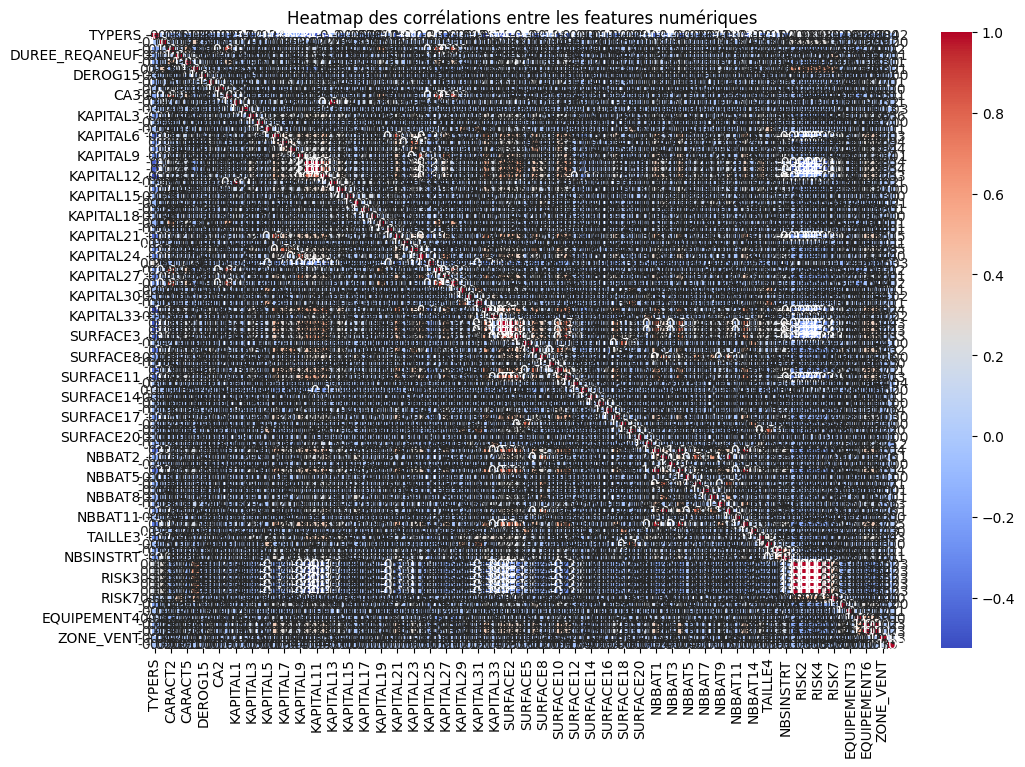

In [ ]:
# 5. Analyse des corrélations
numeric_cols = X_train.select_dtypes(include=['number']).columns
correlation_matrix = X_train[numeric_cols].corr()

# Affichage de la heatmap de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap des corrélations entre les features numériques")
plt.show()

###Analyse
Inexploitable. Il faut trouverv autre chose pour analyser les correlations. Peut être faut-il découper en morceaux.

In [ ]:
# Traitement des valeurs manquantes dans les colonnes numériques
print("Traitement des valeurs manquantes dans les colonnes numériques...")
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Remplir les NaN avec 0 pour les colonnes numériques
X_train[numeric_columns] = X_train[numeric_columns].fillna(0)

# Identifier les colonnes non numériques
fill_cols = [item for item in X_train.columns if item not in numeric_columns]

# Remplir les NaN des colonnes non numériques avec une valeur par défaut (-999)
X_train[fill_cols] = X_train[fill_cols].fillna(-999)

print("Traitement des valeurs manquantes terminé.")

Traitement des valeurs manquantes dans les colonnes numériques...
Traitement des valeurs manquantes terminé.


In [ ]:
# Préparation des données pour l'entraînement
print("Préparation des données pour l'entraînement...")

# Suppression des colonnes inutiles
X_train = X_train.drop(['ID', 'ANNEE_ASSURANCE'], axis=1)

# Encodage des variables catégoriques avec CountEncoder
encoder = CountEncoder(cols=fill_cols)
encoder.fit(X_train)
X_train_enc = encoder.transform(X_train)

print("Préparation terminée.")

Préparation des données pour l'entraînement...
Préparation terminée.


###Analyse
Le chunk précédent fait un encoder.transform() qui remplace les valeurs catégorielles str en int correspondant au nombre d'occurrence de la valeur dans le dataset. Est-ce la bonne transformation ?

###Réduction des colonnes
Pour réduire le nombre de colonnes j'ai tenté le code suivant. Dites moi ce que vous en pensez.

In [ ]:
# Supprimer une des deux colonnes si corrélation trop forte
corr_matrix = X_train_enc.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Colonnes à supprimer : {to_drop}")
#X_train = X_train.drop(to_drop, axis=1)

Colonnes à supprimer : ['CARACT3', 'DEROG8', 'KAPITAL11', 'KAPITAL13', 'KAPITAL35', 'KAPITAL36', 'KAPITAL37', 'KAPITAL38', 'KAPITAL39', 'KAPITAL40', 'KAPITAL41', 'KAPITAL42', 'KAPITAL43', 'SURFACE2', 'SURFACE6', 'NBBAT4', 'NBBAT10', 'NBBAT13', 'RISK2', 'RISK3', 'RISK4', 'RISK5', 'EQUIPEMENT7', 'DISTANCE_112', 'DISTANCE_121', 'DISTANCE_122', 'DISTANCE_123', 'DISTANCE_124', 'DISTANCE_131', 'DISTANCE_132', 'DISTANCE_133', 'DISTANCE_141', 'DISTANCE_142', 'DISTANCE_212', 'DISTANCE_213', 'DISTANCE_221', 'DISTANCE_222', 'DISTANCE_223', 'DISTANCE_243', 'DISTANCE_244', 'DISTANCE_321', 'DISTANCE_322', 'DISTANCE_323', 'DISTANCE_324', 'DISTANCE_331', 'DISTANCE_332', 'DISTANCE_333', 'DISTANCE_334', 'DISTANCE_335', 'DISTANCE_411', 'DISTANCE_412', 'DISTANCE_421', 'DISTANCE_422', 'DISTANCE_423', 'DISTANCE_511', 'DISTANCE_512', 'DISTANCE_521', 'DISTANCE_522', 'DISTANCE_523', 'PROPORTION_14', 'LOG_INC', 'IND', 'IND_0_Y1', 'IND_Y1_Y2', 'IND_Y2_Y3', 'IND_Y6_Y7', 'IND_INC', 'DISTANCE_1', 'ALTITUDE_1', 'ALT

#ATTENTION entrainement des modèles long

Entre 40 mn (avec colonnes supprimées) et 1 heure sous Colab.

In [ ]:
# Entraîner les modèles
print("Entraînement des modèles")

# Modèle pour prédire 'FREQ'
rf_freq = RandomForestRegressor(random_state=42)
rf_freq.fit(X_train_enc, y_train['FREQ'])
print("Modèle pour 'FREQ' entraîné avec succès.")


Entraînement des modèles
Modèle pour 'FREQ' entraîné avec succès.


In [ ]:
# Prédire 'FREQ' sur l'ensemble d'entraînement
y_train_pred_freq = rf_freq.predict(X_train_enc)

In [ ]:
# Modèle pour prédire 'CM'
gb_cm = GradientBoostingRegressor(random_state=42)
gb_cm.fit(X_train_enc, y_train['CM'])
print("Modèle pour 'CM' entraîné avec succès.")

Modèle pour 'CM' entraîné avec succès.


In [ ]:
# Prédire 'CM' sur l'ensemble d'entraînement
y_train_pred_cm = gb_cm.predict(X_train_enc)

In [ ]:
# Calculer la prédiction combinée pour 'CHARGE'
y_train_pred = y_train_pred_freq * y_train_pred_cm * y_train['ANNEE_ASSURANCE']

In [ ]:
# Calculer le RMSE sur l'ensemble d'entraînement
rmse = np.sqrt(mean_squared_error(y_train['CHARGE'], y_train_pred))
print(f"RMSE sur l'ensemble d'entraînement : {rmse:.2f}")

RMSE sur l'ensemble d'entraînement : 6613.76


In [ ]:
# Traitement des données de test
print("Traitement des données de test...")

# Remplir les valeurs manquantes
X_test[numeric_columns] = X_test[numeric_columns].fillna(0)
X_test[fill_cols] = X_test[fill_cols].fillna(-999)

# Suppression des colonnes inutiles
X_test_model = X_test.drop(['ID', 'ANNEE_ASSURANCE'], axis=1)

# Transformation des données de test avec le même encoder
X_test_enc = encoder.transform(X_test_model)

print("Traitement des données de test terminé.")

Traitement des données de test...
Traitement des données de test terminé.


In [ ]:
# Prédictions sur l'ensemble de test
print("Prédictions sur l'ensemble de test...")

# Prédire 'FREQ' et 'CM' sur les données de test
y_pred_freq = rf_freq.predict(X_test_enc)
y_pred_cm = gb_cm.predict(X_test_enc)

Prédictions sur l'ensemble de test...


In [ ]:
# Combiner les prédictions
y_pred = pd.concat([
    X_test[['ID', 'ANNEE_ASSURANCE']].reset_index(drop=True),
    pd.DataFrame(y_pred_freq, columns=['FREQ']),
    pd.DataFrame(y_pred_cm, columns=['CM'])
], axis=1)

In [ ]:
# Calculer la colonne 'CHARGE' en multipliant 'FREQ', 'CM' et 'ANNEE_ASSURANCE'
y_pred['CHARGE'] = y_pred['CM'] * y_pred['FREQ'] * y_pred['ANNEE_ASSURANCE']

print("Prédictions terminées.")

Prédictions terminées.


In [ ]:
# Exporter les prédictions dans un fichier CSV
print("Exportation des résultats...")
y_pred.to_csv('submission.csv', index=False)
print("Fichier de soumission créé : 'submission.csv'")

Exportation des résultats...
Fichier de soumission créé : 'submission.csv'
